In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama
import pandas as pd

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_memory_usage()
sc.logging.print_header()
sc.set_figure_params(dpi=100)

Memory usage: current 0.21 GB, difference +0.00 GB
scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


## P38

In [4]:
P38_gaba = sc.read_h5ad('P38gaba_raw.h5ad')

In [5]:
sc.pp.highly_variable_genes(P38_gaba, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs
sc.pp.scale(P38_gaba, max_value=10) #scale

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [6]:
P38_gaba_CBs = list(P38_gaba.obs.index)
P38_gaba_batch = []
for i in range(len(P38_gaba_CBs)):
    P38_gaba_batch.append(P38_gaba_CBs[i][19:25])
    
P38_gaba.obs['sample'] = P38_gaba.obs['batch']
P38_gaba.obs['sample'] = P38_gaba_batch

In [7]:
sc.tl.pca(P38_gaba, svd_solver='arpack') #run PCA
#sc.pp.neighbors(P38_gaba, n_neighbors=25, n_pcs=40) #choose 25 standard for now
bbknn(P38_gaba, batch_key='sample',neighbors_within_batch=8 ) #8*3~=25
sc.tl.leiden(P38_gaba)
sc.tl.umap(P38_gaba)

computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:02)
running Leiden clustering


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


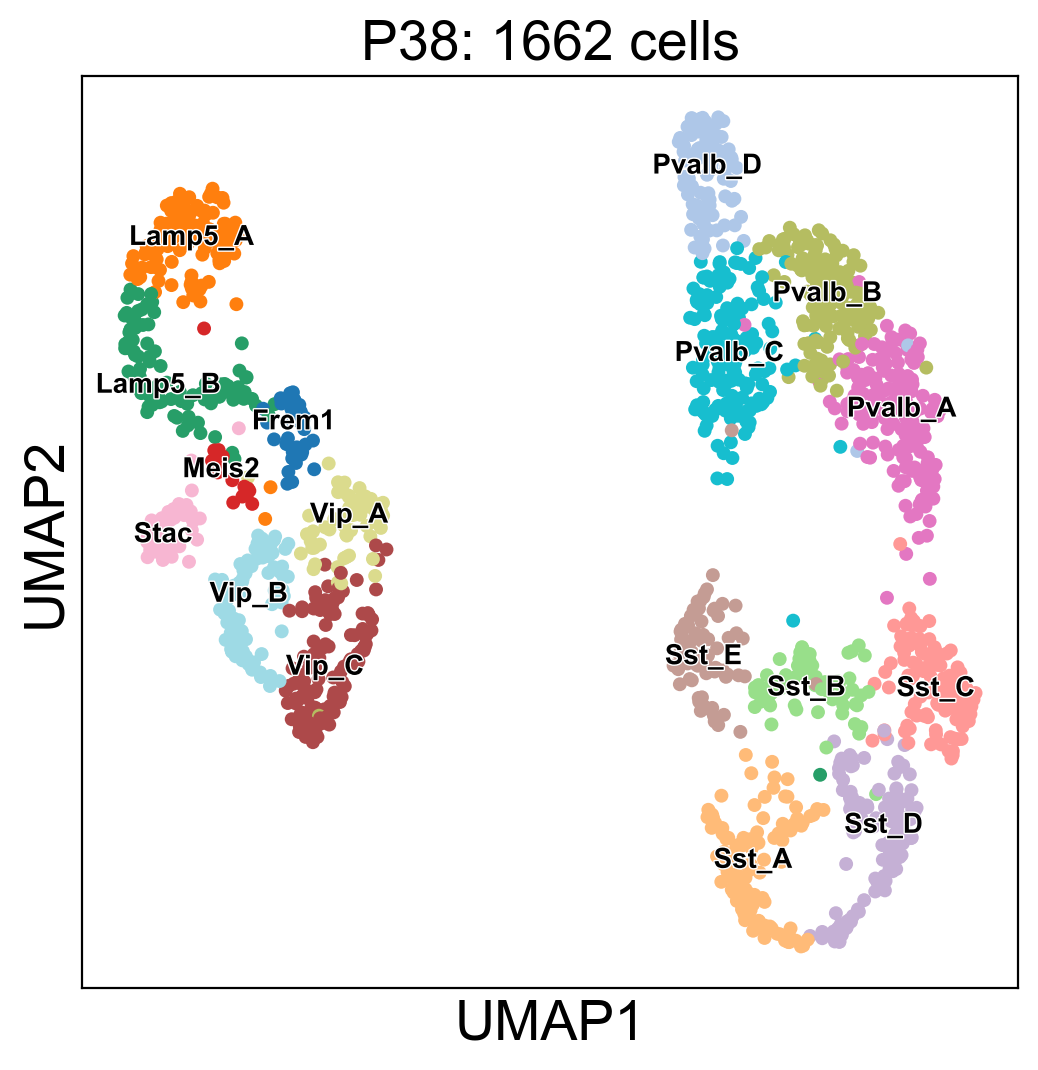

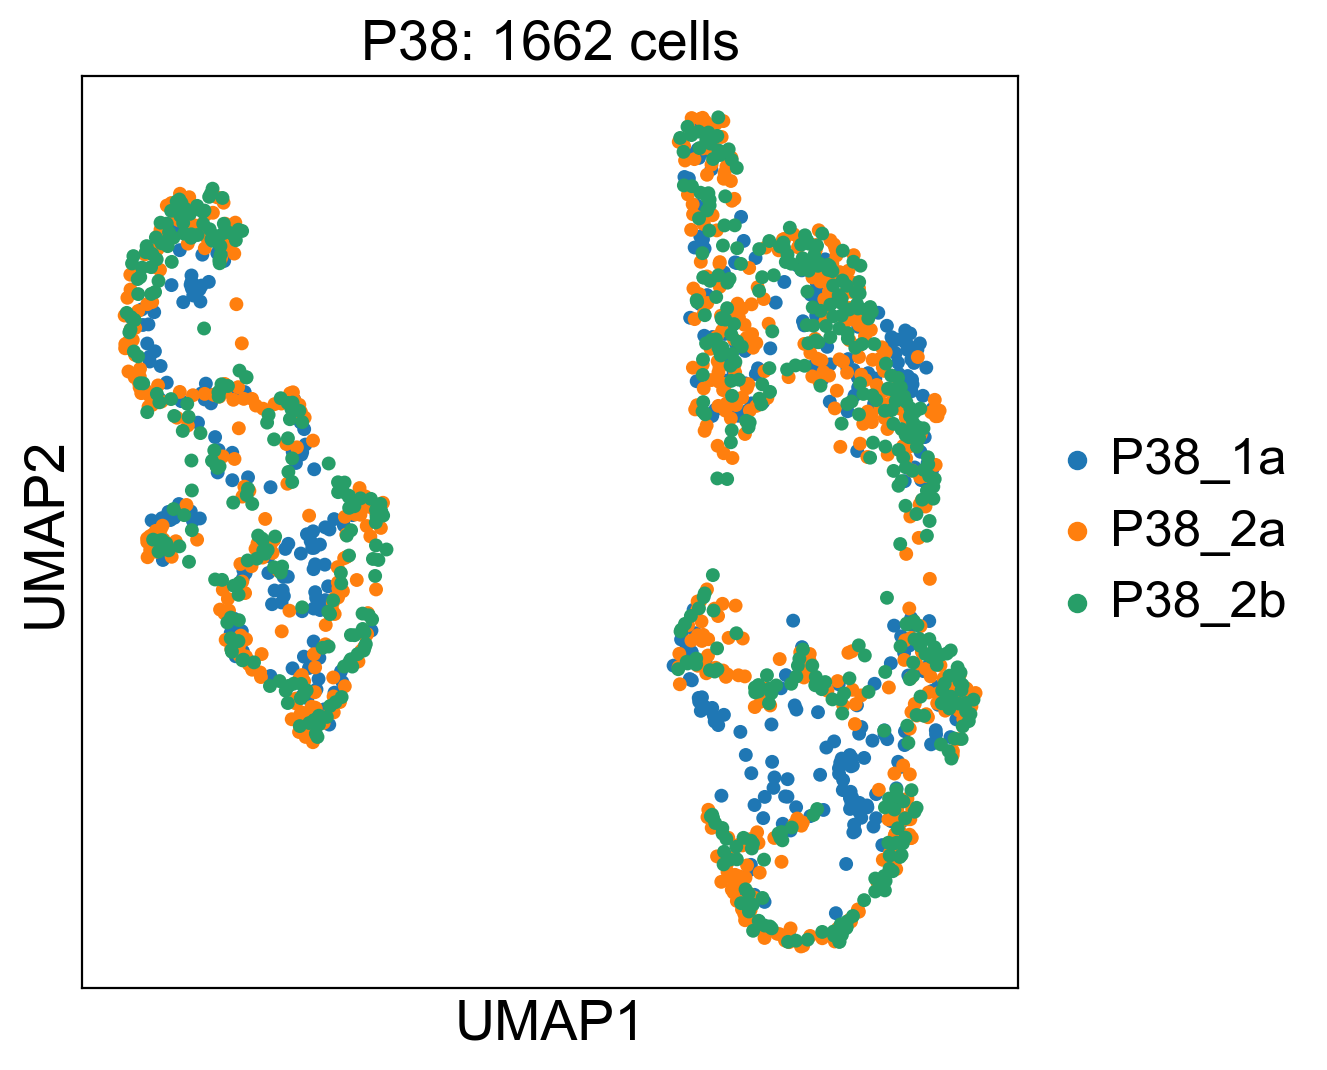

In [12]:
umap_colors = ['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a',
 '#ff9896',
 '#c5b0d5',
 '#c49c94',
 '#f7b6d2',
 '#dbdb8d',
 '#9edae5',
 '#ad494a']
sc.set_figure_params(dpi=100, figsize=(6,6), dpi_save=2000, fontsize=20)
sc.pl.umap(P38_gaba, color='cluster_name', 
           title = 'P38: ' + str(P38_gaba.shape[0]) + ' cells', frameon=True, legend_loc='on data', legend_fontoutline=1,size=100, legend_fontsize='10', palette=umap_colors)
sc.pl.umap(P38_gaba, color='sample', title = 'P38: ' + str(P38_gaba.shape[0]) + ' cells', frameon=True, size = 100)


bias_markers = ['Snap25', 'Slc17a7', 'Gad1', 'Gad2', 'Pvalb', 'Sst', 'Lamp5', 'Vip', 'Serpinf1', 'Sncg', 'Meis2', 'Igsf9b',
                'Pax6']

bias_pos = [(0,8), (9,17)]
bias_labels = ['Neuronal', 'Non-Neuronal']
#sc.pl.dotplot(P38_gaba, bias_markers, groupby='leiden', dendrogram=True, show=False)

P38_gaba = P38_gaba[P38_gaba.obs['leiden']!='15',:]

After mapping, Vip_3 doesn't map to any Vips, so it should be `Ambig_3`

cluster_dict = {0:'Vip_1', 1:'Pvalb_1', 2:'Pvalb_3', 3:'Pvalb_2', 4:'Lamp5_1', 5:'Sst_2', 6:'Sst_3', 7:'Sst_4', 
                8:'Lamp5_2', 9:'Pvalb_4', 10:'Vip_2', 11:'Sst_1', 12:'Sst_5', 13:'Ambig_2', 14:'Ambig_3', 16:'Ambig_1'}

cluster = []
for i in cluster_dict: cluster.append((cluster_dict[i]))

P38_gaba.obs['cluster'] = P38_gaba.obs['leiden']
P38_gaba.rename_categories(key='cluster', categories=cluster)

### Finalize type names P38

In [20]:
P38_gaba.obs['cluster_name'] = P38_gaba.obs['cluster']
P38_gaba.obs['cluster_name'] = pd.Series(cluster_namesP38, dtype="category").values #47 in 'remove'

In [21]:
P38_gaba = P38_gaba[P38_gaba.obs['cluster_name']!='remove',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['cluster_name']"]`


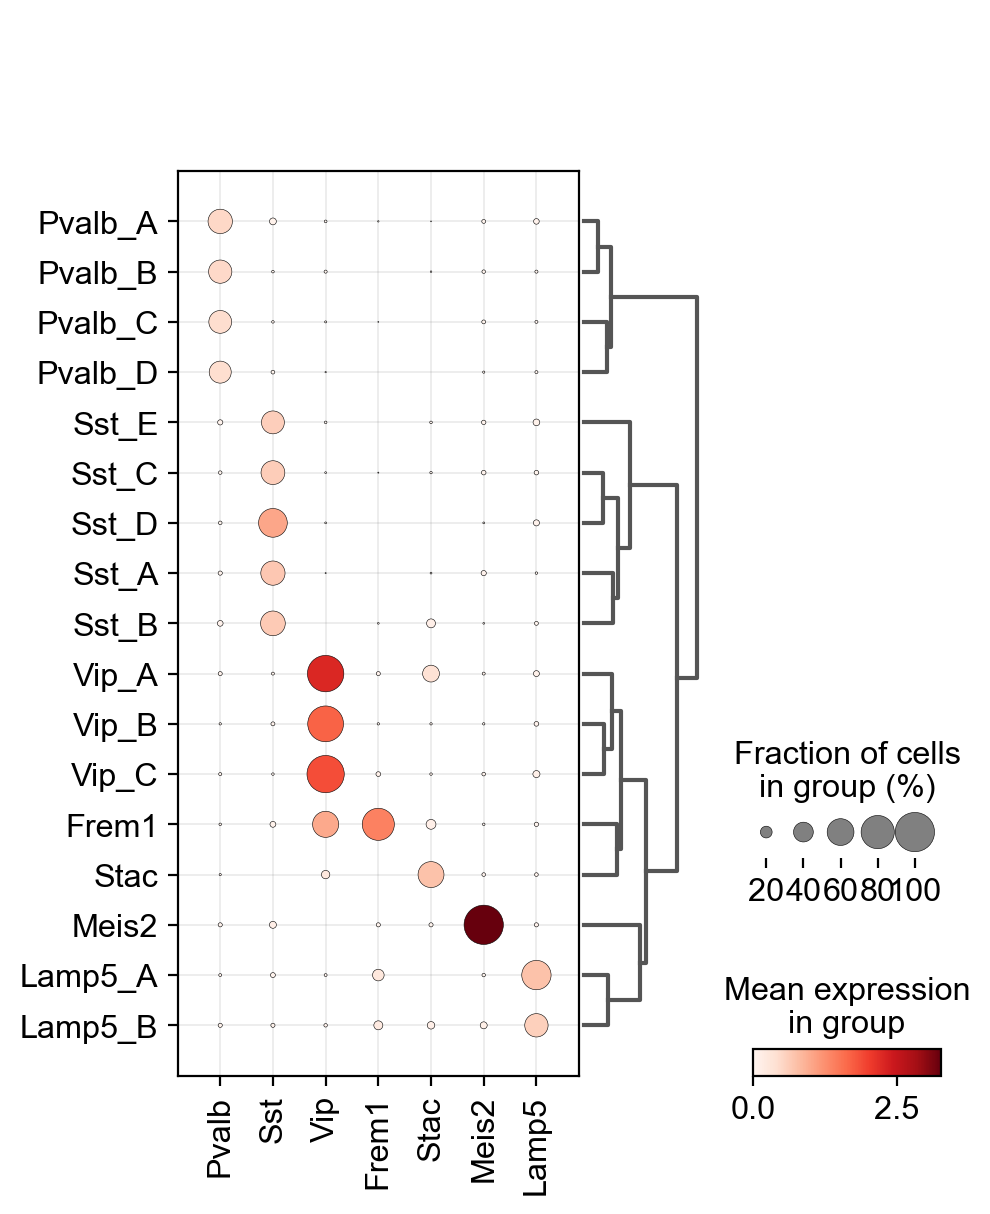

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


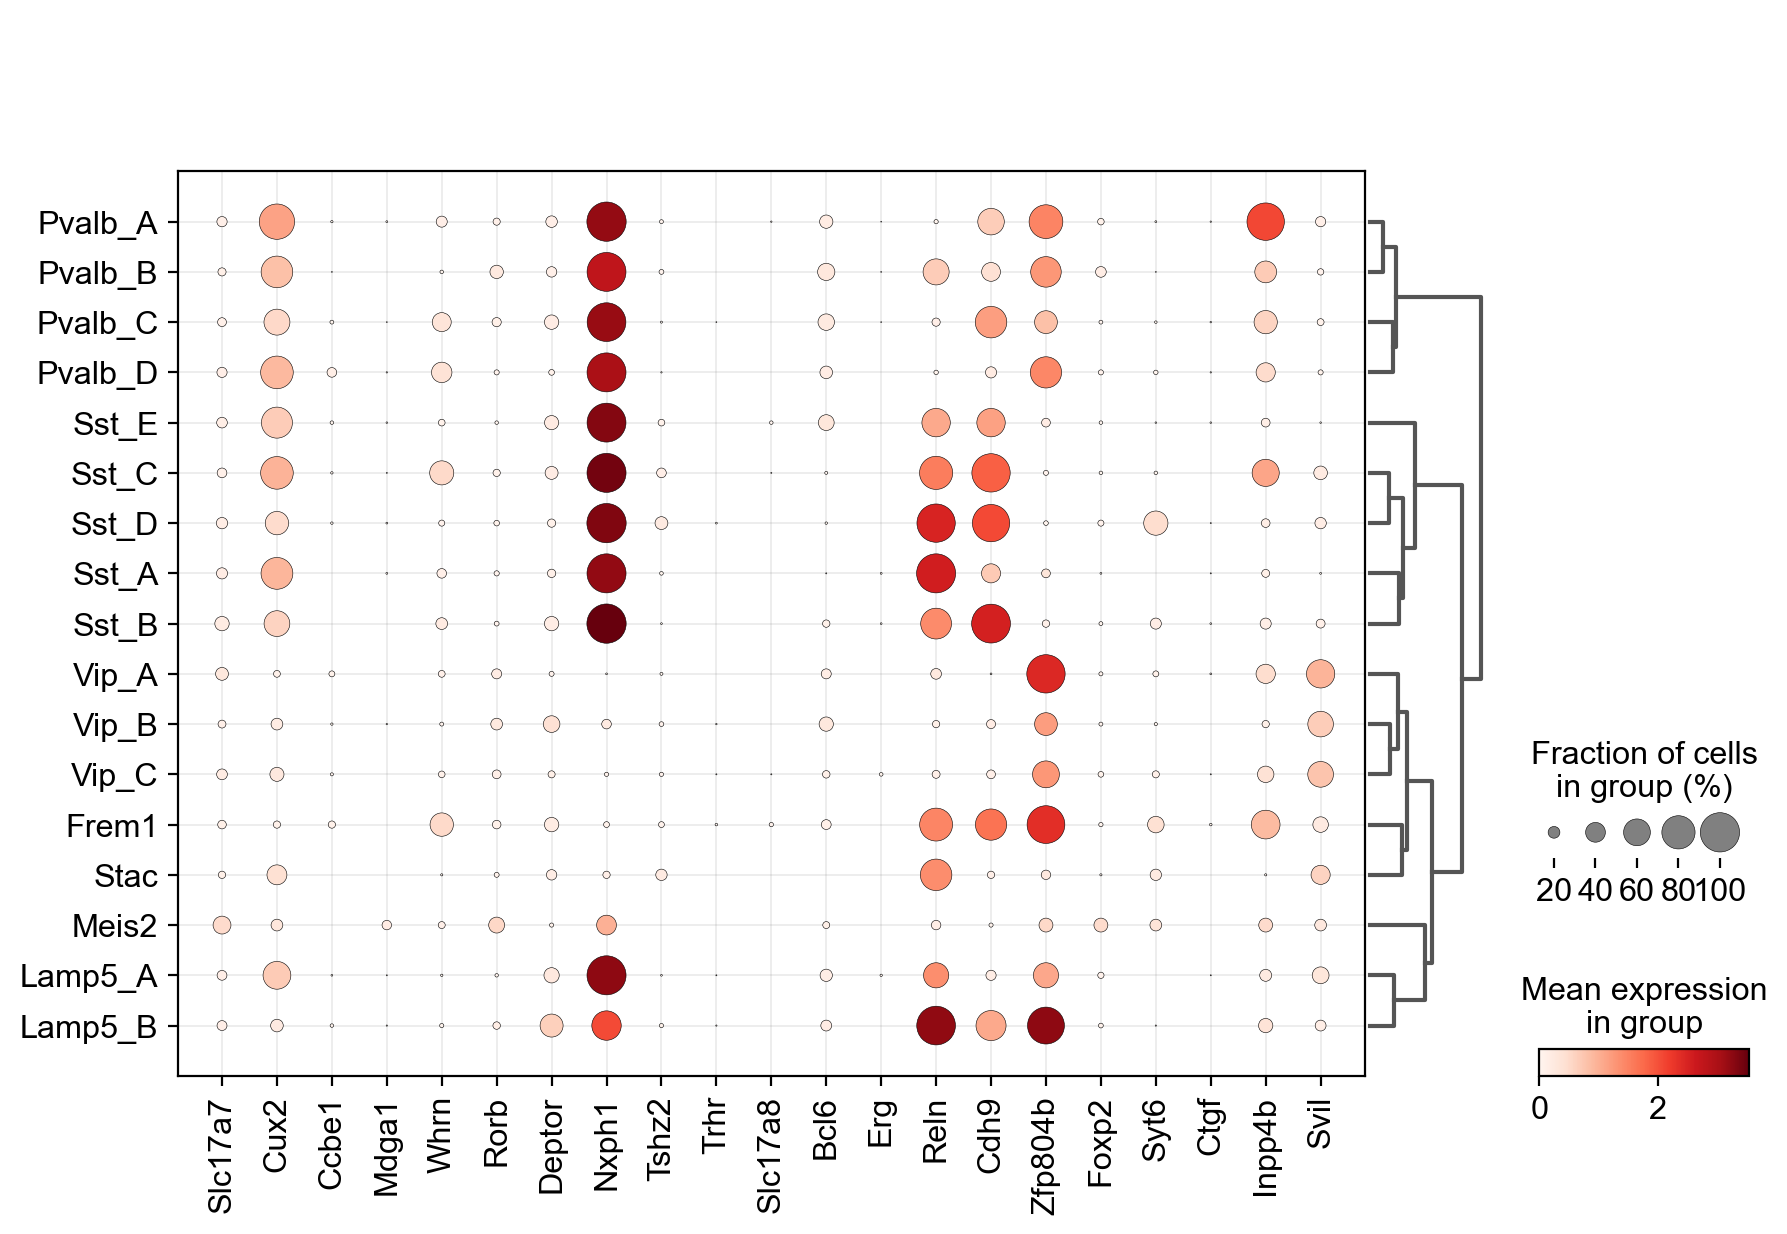

In [9]:
bias_markers = ['Pvalb', 'Sst', 'Vip', 'Frem1', 'Stac', 'Meis2', 'Lamp5']
layer_markers = ['Slc17a7',
    'Cux2', 'Ccbe1', 'Mdga1', 
              'Whrn', 'Rorb',
              'Deptor', 
              'Nxph1', 'Tshz2', 'Trhr', 'Slc17a8', 
              'Bcl6', 'Erg', 'Reln', 
              'Cdh9', 'Zfp804b',
              'Foxp2', 'Syt6',
              'Ctgf', 'Inpp4b', 'Svil']

bias_pos = [(0,8), (9,17)]
bias_labels = ['Neuronal', 'Non-Neuronal']
sc.pl.dotplot(P38_gaba, bias_markers, groupby='cluster_name', dendrogram=True,  return_fig=True).style(cmap='Reds', grid=True).show()
sc.pl.dotplot(P38_gaba, layer_markers, groupby='cluster_name', dendrogram=True,  return_fig=True).style(cmap='Reds', grid=True).show()

# Save

In [ ]:
P38_gaba.write_h5ad('P38_gaba0828.h5ad')